In [1]:
!pip install vector
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.6/182.6 kB 6.5 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 24.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 15.0 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# The classics
import numpy as np
import matplotlib.pylab as plt
import matplotlib # To get the version

import pandas as pd

# The newcomers
import awkward as ak
import uproot

import vector
vector.register_awkward()

In [85]:
####### Backgrounds
# W+jets
#dataset = "Wjets"
#filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/00702195-E707-3743-8BBA-57EB9DEE1DBA.root'

# ttbar leptonic
#dataset = "tt_lep"
#filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIIFall15MiniAODv2/TTTo2L2Nu_13TeV-powheg/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1/00000/02A468DA-E8B9-E511-942C-0022195E688C.root'

# ttbar hadronic
#dataset = "tt_had"
#filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/009086DB-1E42-7545-9A35-1433EC89D04B.root'

# ttbar semileptonic
dataset = "tt_semilep"
filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root'


########### Signal
#dataset = 'signal'
#filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/ZprimeToTT_M2000_W20_TuneCP2_PSweights_13TeV-madgraph-pythiaMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/22BAB5D2-9E3F-E440-AB30-AE6DBFDF6C83.root'


# Open the file 
f = uproot.open(filename)

events = f['Events']

nevents = events.num_entries

print(f"{nevents = }")

nevents = 1233000


In [86]:
fatjet_tag = events['FatJet_particleNet_TvsQCD'].array()

fatjet_pt = events['FatJet_pt'].array()
fatjet_eta = events['FatJet_eta'].array()
fatjet_phi = events['FatJet_phi'].array()
fatjet_mass = events['FatJet_mass'].array()

In [87]:
muon_pt = events['Muon_pt'].array()
muon_eta = events['Muon_eta'].array()
muon_phi = events['Muon_phi'].array()
muon_mass = events['Muon_mass'].array()

muon_iso = events['Muon_miniIsoId'].array()
muon_tightId = events['Muon_tightId'].array()

In [88]:
jet_btag = events['Jet_btagDeepB'].array()
jet_jetid = events['Jet_jetId'].array()

jet_pt = events['Jet_pt'].array()
jet_eta = events['Jet_eta'].array()
jet_phi = events['Jet_phi'].array()
jet_mass = events['Jet_mass'].array()

In [89]:
met_pt = events['PuppiMET_pt'].array()
met_eta = 0*events['PuppiMET_pt'].array()  # Fix this to be 0
met_phi = events['PuppiMET_phi'].array() 

ht_lep = muon_pt + met_pt

In [90]:
# Cuts
tau32 = fatjet_tau3/fatjet_tau2

#cut_fatjet = (tau32>0.67) & (fatjet_eta>-2.4) & (fatjet_eta<2.4) & (fatjet_mSD>105) & (fatjet_mSD<220)
cut_fatjet = (fatjet_pt > 500) & (fatjet_tag > 0.5)

cut_muon = (muon_pt>55) & (muon_eta>-2.4) & (muon_eta<2.4) & \
           (muon_tightId == True) & (muon_iso>1) & (ht_lep>150)

cut_jet = (jet_btag > 0.5) & (jet_jetid>=4)



# Event cut
cut_met = (met_pt > 50)

cut_nmuons = (ak.num(cut_muon[cut_muon]) == 1)

cut_trigger = (events['HLT_TkMu50'].array())

cut_btag = (ak.num(cut_jet[cut_jet]) > 0)

cut_ntop = (ak.num(cut_fatjet[cut_fatjet]) == 1)

cut_full_event = cut_trigger & cut_nmuons & cut_met & cut_ntop & cut_btag
print(ak.sum(cut_full_event))

597


In [91]:
fatjets = ak.zip(
    {"pt": fatjet_pt[cut_full_event][cut_fatjet[cut_full_event]], 
     "eta": fatjet_eta[cut_full_event][cut_fatjet[cut_full_event]], 
     "phi": fatjet_phi[cut_full_event][cut_fatjet[cut_full_event]], 
     "mass": fatjet_mass[cut_full_event][cut_fatjet[cut_full_event]]},
    with_name="Momentum4D",
)

muons = ak.zip(
    {"pt": muon_pt[cut_full_event][cut_muon[cut_full_event]], 
     "eta": muon_eta[cut_full_event][cut_muon[cut_full_event]], 
     "phi": muon_phi[cut_full_event][cut_muon[cut_full_event]], 
     "mass": muon_mass[cut_full_event][cut_muon[cut_full_event]]},
    with_name="Momentum4D",
)

jets = ak.zip(
    {"pt": jet_pt[cut_full_event][cut_jet[cut_full_event]][:,0], 
     "eta": jet_eta[cut_full_event][cut_jet[cut_full_event]][:,0], 
     "phi": jet_phi[cut_full_event][cut_jet[cut_full_event]][:,0], 
     "mass": jet_mass[cut_full_event][cut_jet[cut_full_event]][:,0]},
    with_name="Momentum4D",
)

met = ak.zip(
    {"pt": met_pt[cut_full_event], 
     "eta": met_eta[cut_full_event], 
     "phi": met_phi[cut_full_event], 
     "mass": 0},
    with_name="Momentum4D",
)

In [92]:
p4mu,p4fj,p4j,p4met = ak.unzip(ak.cartesian([muons, fatjets, jets, met]))
p4tot = p4mu + p4fj + p4j + p4met

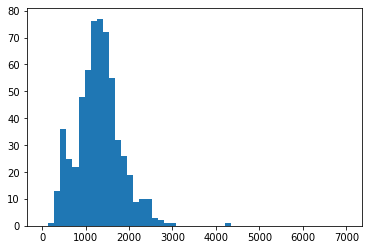

In [93]:
plt.hist(ak.flatten(p4tot.mass),bins=50, range=(0,7000));


In [94]:
weights = events['genWeight'].array()
nTrueInt = events['Pileup_nTrueInt'].array()

mydict = {}
print(p4tot.mass)
print(p4mu.pt)
mydict['mtt'] = ak.flatten(p4tot.mass)
mydict['mu_pt'] = ak.flatten(p4mu.pt) 
mydict['mu_abseta'] = np.abs(ak.flatten(p4mu.eta))
mydict['weight'] = weights[cut_full_event]
mydict['pileup'] = nTrueInt[cut_full_event]

print(len(mydict['mtt']))
print(len(mydict['mu_pt']))
print(len(mydict['mu_abseta']))
print(len(mydict['weight']))
print(len(mydict['pileup']))

df = pd.DataFrame.from_dict(mydict)

df

outfilename = f"output_{dataset}_{filename.split('/')[-1].split('.')[0]}.csv"
print(outfilename)

df.to_csv(outfilename, index=False)

[[1.66e+03], [625], [1.55e+03], [1.5e+03, ... [1.09e+03], [952], [1.85e+03]]
[[210], [248], [210], [58.7], [64.5], ... [130], [263], [148], [96.3], [58.9]]
597
597
597
597
597
output_tt_semilep_08FCB2ED-176B-064B-85AB-37B898773B98.csv
